In [103]:
import Pkg
Pkg.activate("../../.")

  Activating project at `~/Documents/MPSTime.jl`


In [80]:
using Plots
using JLD2
using MPSTime
using Plots.PlotMeasures
using Random
using StatsPlots
using Printf
using DataFrames

# NTS1

In [139]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS1_chi20_f = jldopen("NTS1_Results/NTS1_rand_250_chi20_10sw.jld2");
NTS1_chi20_res = read(NTS1_chi20_f, "res")
losses_chi20 = NTS1_chi20_res[1]["loss"] # get the errors
window_lengths20 = [length(NTS1_chi20_res[1]["eval_windows"][i]) for i in 1:length(NTS1_chi20_res[1]["eval_windows"])]
NTS1_chi20_pm = [mean(losses_chi20[findall(x -> x .== pm, window_lengths20)]) for pm in 5:10:95]
NTS1_chi_20_pm_stds = [std(losses_chi20[findall(x -> x .== pm, window_lengths20)]) for pm in 5:10:95]
params_NTS1_chi20 = NTS1_chi20_res[1]["opts"]
println("Optimal params: d = $(params_NTS1_chi20.d), χ = $(params_NTS1_chi20.chi_max), η = $(params_NTS1_chi20.eta), sweeps = $(params_NTS1_chi20.nsweeps)")

Optimal params: d = 12, χ = 20, η = 0.4524942412773705, sweeps = 10


In [140]:
NTS1_chi20_res[1]["cache"]

Dict{Tuple{Int64, Float64}, Float64} with 250 entries:
  (12, 0.00105118) => 0.275115
  (12, 0.00152851) => 0.273076
  (5, 0.120541)    => 0.13917
  (9, 0.0528979)   => 0.107794
  (10, 0.0107085)  => 0.144946
  (12, 0.0194926)  => 0.131271
  (9, 0.026299)    => 0.113979
  (14, 0.00331347) => 0.253662
  (11, 0.00493982) => 0.177887
  (12, 0.0731726)  => 0.106598
  (11, 0.0542348)  => 0.106409
  (8, 0.00458346)  => 0.15893
  (11, 0.00921918) => 0.156516
  (7, 0.106399)    => 0.111901
  (8, 0.00969104)  => 0.135839
  (10, 0.370595)   => 0.103844
  (13, 0.0127527)  => 0.159795
  (14, 0.158623)   => 0.107509
  (11, 0.103776)   => 0.104143
  ⋮                => ⋮

[20.0]
[3.0]
[3.2748828620072237, 3.687015596584574, 5.597555946335841, 1.1995021663608285, 3.3028342150738745, 2.4541385133468347, 0.28159983062300115, 5.864431661027651, 3.647765948050564, 2.0560962348956884, 3.311213013928832, 5.254179096211399, 0.25702083286268734, 2.922947263489122, 2.278592919410931, 0.6421704818162451, 4.524537821452053, 3.604155996194438, 4.1749785826210095, 1.8558424829083464, 1.7379130098099467, 6.179108810663886, 5.53484217142524, 1.4703709556726416, 2.393575542709661, 0.8290269216666165, 0.5547488341678436, 1.9698094725635538, 2.912945933807586, 4.483906742840891, 1.2938643656691822, 0.5689497445611652, 3.656263079756512, 1.956882360387792, 0.7611923209207326, 1.2850987430674075, 2.429645950020418, 0.11669131494844684, 0.45352486262226865, 5.744380715941141, 2.4339430163340747, 4.850093505415513, 2.3711689508434195, 5.501274308860625, 1.6623306522699093, 5.666662354367938, 5.433026931069933, 4.600787993089094, 0.6484049096812825, 3.6919050379075076, 5.08581

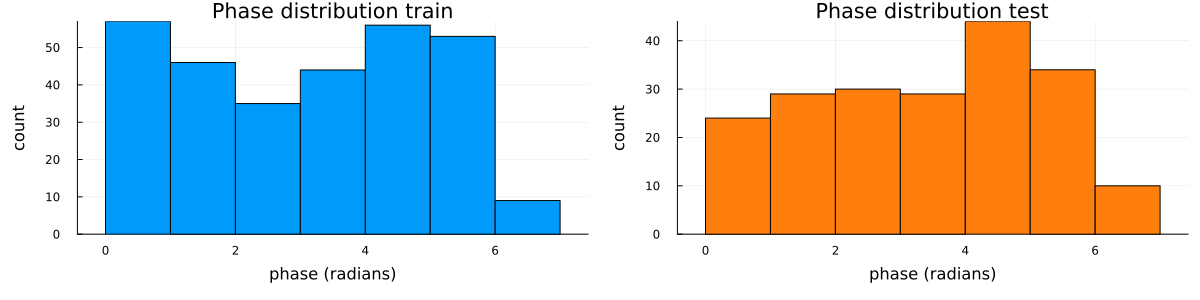

In [141]:
#load the dataset
nts1_dataset_loaded = jldopen("/Users/jmoo2880/Documents/MPSTime.jl/Folds/NTS/NTS1_dataset.jld2")
NTS1_X_train = read(nts1_dataset_loaded, "X_train")
NTS1_X_test = read(nts1_dataset_loaded, "X_test")
NTS1_train_info = read(nts1_dataset_loaded, "train_info")
NTS1_test_info = read(nts1_dataset_loaded, "test_info")
NTS1_eval_windows = read(nts1_dataset_loaded, "eval_windows");
println(unique(NTS1_train_info[:period]))
println(unique(NTS1_train_info[:slope]))
println(unique(NTS1_train_info[:phase]))
h1 = histogram(unique(NTS1_train_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution train")
h2 = histogram(unique(NTS1_test_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution test", c=palette(:tab10)[2])
plot(h1, h2, size=(1200, 300), bottom_margin=10mm, left_margin=8mm)

In [142]:
# train NN
opts = MPSOptions(; chi_max=5, d=3, nsweeps=1, sigmoid_transform=false, log_level=-1, verbosity=-5) #doesn't matter, only need the 1NN
mps, _, _ = fitMPS(NTS1_X_train, opts)
imp_NTS1 = init_imputation_problem(mps, NTS1_X_test; verbosity=0)
pms = 5:10:95
pm_losses_NTS1 = []
for pm in pms
    losses = []
    for i in 1:size(NTS1_X_test, 1)
        for window in NTS1_eval_windows[pm]
            out = MPSTime.get_predictions(imp_NTS1, 0, i, window, :kNearestNeighbour)
            loss = MPSTime.compute_all_forecast_metrics(out[1][1][window], NTS1_X_test[i, :][window], false)[:MAE]
            push!(losses, loss)
        end
    end
    push!(pm_losses_NTS1, losses)
end
knn_means_nts1 = mean.(pm_losses_NTS1)
knn_std_nts1 = std.(pm_losses_NTS1)

10-element Vector{Float64}:
 0.03782530509517891
 0.022685518580452313
 0.01806125347114823
 0.015167607866076594
 0.014100129899652066
 0.013347582128870451
 0.012725887207379369
 0.012675053560386665
 0.013592835037735876
 0.027220410981151348

In [143]:
plot(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi20.chi_max)", c=palette(:tab10)[1], yerr=NTS1_chi_20_pm_stds, 
    msc=palette(:tab10)[1])
plot!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, msw=0), #yerr=knn_std_nts1)
title!("NTS1 χ = $(params.chi_max), d = $(params.d), η = $(round(params.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

ErrorException: type #params has no field chi_max

In [144]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS1_chi30_f = jldopen("NTS1_Results/NTS1_rand_250_chi30_10sw.jld2");
NTS1_chi30_res = read(NTS1_chi30_f, "res")
losses_chi30 = NTS1_chi30_res[1]["loss"] # get the errors
window_lengths30 = [length(NTS1_chi30_res[1]["eval_windows"][i]) for i in 1:length(NTS1_chi30_res[1]["eval_windows"])]
NTS1_chi30_pm = [mean(losses_chi30[findall(x -> x .== pm, window_lengths30)]) for pm in 5:10:95]
NTS1_chi_30_pm_stds = [std(losses_chi30[findall(x -> x .== pm, window_lengths30)]) for pm in 5:10:95]
params_NTS1_chi30 = NTS1_chi30_res[1]["opts"]
println("Optimal params: d = $(params_NTS1_chi30.d), χ = $(params_NTS1_chi30.chi_max), η = $(params_NTS1_chi30.eta), sweeps = $(params_NTS1_chi30.nsweeps)")

Optimal params: d = 12, χ = 30, η = 0.1365619413848237, sweeps = 10


┌ Warning: saved type MPSOptions is missing field svd_alg in workspace type; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:195


In [145]:
plot(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi30.chi_max)", c=palette(:tab10)[2], yerr=NTS1_chi_30_pm_stds, 
    msc=palette(:tab10)[2])
plot!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, msw=0),
title!("NTS1 χ = $(params.chi_max), d = $(params.d), η = $(round(params.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

ErrorException: type #params has no field chi_max

In [146]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS1_chi40_f = jldopen("NTS1_Results/NTS1_rand_250_chi40_10sw.jld2");
NTS1_chi40_res = read(NTS1_chi40_f, "res")
losses_chi40 = NTS1_chi40_res[1]["loss"] # get the errors
window_lengths40 = [length(NTS1_chi40_res[1]["eval_windows"][i]) for i in 1:length(NTS1_chi40_res[1]["eval_windows"])]
NTS1_chi40_pm = [mean(losses_chi40[findall(x -> x .== pm, window_lengths40)]) for pm in 5:10:95]
NTS1_chi_40_pm_stds = [std(losses_chi40[findall(x -> x .== pm, window_lengths40)]) for pm in 5:10:95]
params_NTS1_chi40 = NTS1_chi40_res[1]["opts"]
println("Optimal params: d = $(params_NTS1_chi40.d), χ = $(params_NTS1_chi40.chi_max), η = $(params_NTS1_chi40.eta), sweeps = $(params_NTS1_chi40.nsweeps)")

Optimal params: d = 11, χ = 40, η = 0.1037762744463832, sweeps = 10


┌ Warning: saved type MPSOptions is missing field svd_alg in workspace type; reconstructing
└ @ JLD2 /Users/jmoo2880/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:195


In [147]:
plot(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi40.chi_max)", c=palette(:tab10)[3], yerr=NTS1_chi_40_pm_stds, 
    msc=palette(:tab10)[3])
plot!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts1)
title!("NTS1 χ = $(params.chi_max), d = $(params.d), η = $(round(params.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

ErrorException: type #params has no field chi_max

Combined

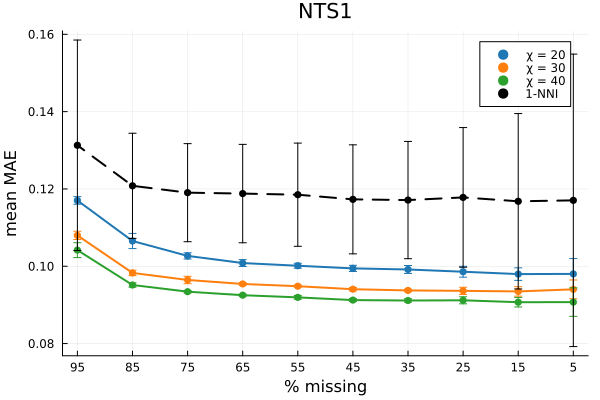

In [148]:
plot(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi20.chi_max)", c=palette(:tab10)[1], yerr=NTS1_chi_20_pm_stds, 
    msc=palette(:tab10)[1])

plot!(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi30.chi_max)", c=palette(:tab10)[2], yerr=NTS1_chi_30_pm_stds, 
    msc=palette(:tab10)[2])

plot!(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi40.chi_max)", c=palette(:tab10)[3], yerr=NTS1_chi_40_pm_stds, 
    msc=palette(:tab10)[3])

plot!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts1), 

title!("NTS1")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

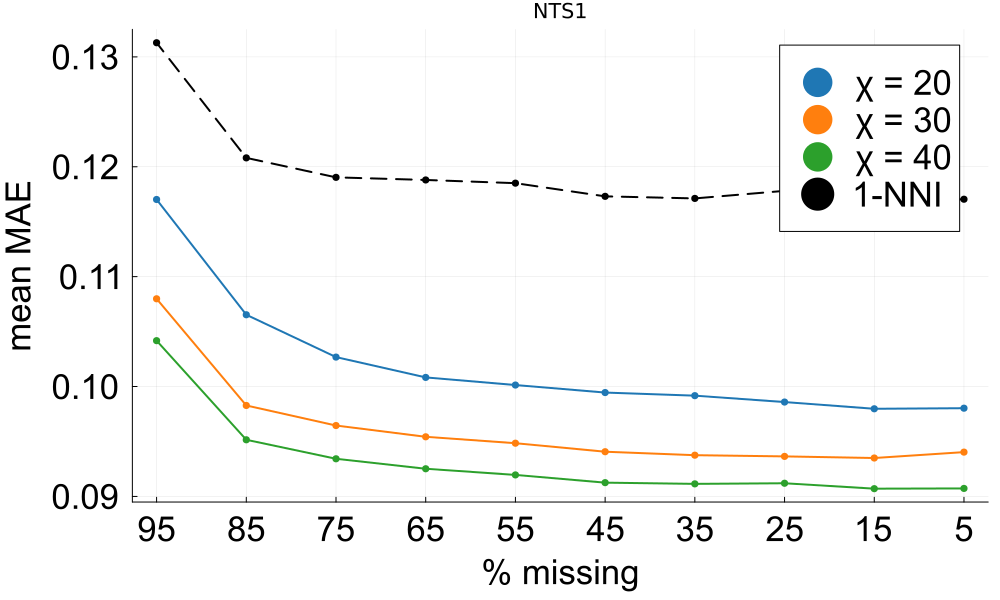

In [151]:
plot(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi20_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi20.chi_max)", c=palette(:tab10)[1],
    msc=palette(:tab10)[1], size=(1000, 600),
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, legendfont=fstyle, left_margin=5mm, bottom_margin=8mm)

plot!(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi30_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi30.chi_max)", c=palette(:tab10)[2],
    msc=palette(:tab10)[2])

plot!(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS1_chi40_pm, xticks=collect(5:10:95), label="χ = $(params_NTS1_chi40.chi_max)", c=palette(:tab10)[3], 
    msc=palette(:tab10)[3])

plot!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts1, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, msw=0)

title!("NTS1")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)
#savefig("NTS1_lineplot.svg")

### NTS1 Example Imputations

With the $\chi_{\rm max} = 40$ MPS

In [81]:
params_NTS1_chi40

Reconstruct@MPSOptions(Any[-5, 10, 40, 0.1037762744463832, 11, :Legendre_No_Norm, false, 2, 1.0e-10, 1, Float64, :KLD, :TSGO, false, (false, true), false, false, false, true, false, false, 1234, 4, -1, (0.0, 1.0), false])

In [87]:
# train NN
opts_NTS1_chi40_rec = MPSOptions(; d=params_NTS1_chi40.d, chi_max=params_NTS1_chi40.chi_max, nsweeps=params_NTS1_chi40.nsweeps, eta=params_NTS1_chi40.eta, sigmoid_transform=false, log_level=-1, verbosity=-5)
mps, _, _ = fitMPS(NTS1_X_train, opts_NTS1_chi40_rec)
imp_NTS1 = init_imputation_problem(mps, NTS1_X_test; verbosity=0)

ImputationProblem(ITensors.ITensorMPS.MPS[ITensors.ITensorMPS.MPS
[1] ((dim=11|id=831|"Site,n=1"), (dim=11|id=485|"Link,l=1"))
[2] ((dim=11|id=530|"Site,n=2"), (dim=11|id=485|"Link,l=1"), (dim=40|id=632|"Link,l=2"))
[3] ((dim=11|id=190|"Site,n=3"), (dim=40|id=632|"Link,l=2"), (dim=40|id=639|"Link,l=3"))
[4] ((dim=11|id=631|"Site,n=4"), (dim=40|id=639|"Link,l=3"), (dim=40|id=84|"Link,l=4"))
[5] ((dim=11|id=562|"Site,n=5"), (dim=40|id=84|"Link,l=4"), (dim=40|id=844|"Link,l=5"))
[6] ((dim=11|id=437|"Site,n=6"), (dim=40|id=844|"Link,l=5"), (dim=40|id=961|"Link,l=6"))
[7] ((dim=11|id=779|"Site,n=7"), (dim=40|id=961|"Link,l=6"), (dim=40|id=128|"Link,l=7"))
[8] ((dim=11|id=89|"Site,n=8"), (dim=40|id=128|"Link,l=7"), (dim=40|id=432|"Link,l=8"))
[9] ((dim=11|id=327|"Site,n=9"), (dim=40|id=432|"Link,l=8"), (dim=40|id=124|"Link,l=9"))
[10] ((dim=11|id=279|"Site,n=10"), (dim=40|id=124|"Link,l=9"), (dim=40|id=603|"Link,l=10"))
[11] ((dim=11|id=901|"Site,n=11"), (dim=40|id=603|"Link,l=10"), (dim=40|

In [96]:
imputed_ts_nts1, pred_err_nts1, target_ts_nts1, stats_nts1, plots_nts1 = MPS_impute(imp_NTS1, 0, 1, collect(25:75), :median, NN_baseline=false)
imputed_ts_nts2, pred_err_nts2, target_ts_nts2, stats_nts2, plots_nts2 = MPS_impute(imp_NTS1, 0, 3, collect(1:90), :median, NN_baseline=false)
imputed_ts_nts3, pred_err_nts3, target_ts_nts3, stats_nts3, plots_nts3 = MPS_impute(imp_NTS1, 0, 10, collect(50:95), :median, NN_baseline=false)
imputed_ts_nts4, pred_err_nts4, target_ts_nts4, stats_nts4, plots_nts4 = MPS_impute(imp_NTS1, 0, 14, vcat(collect(10:25), collect(50:75)), :median, NN_baseline=false)

([[0.0700059657304446, 0.3037085794704455, 0.8025955467773951, 1.0660003280072319, 1.2123775045656262, 1.1693401649752229, 1.0988178931550836, 0.9656401073572307, 0.7127442773663579, 0.6199667971430487  …  2.593427254621443, 2.2200886593516453, 2.122285890554753, 2.065089769998028, 1.8340071868070797, 1.8468105078134167, 1.9350257751372868, 2.2976837366299407, 2.4641956046232982, 2.710448467695757]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.07000596573044462, 0.3037085794704455, 0.8025955467773949, 1.0660003280072319, 1.2123775045656264, 1.1693401649752229, 1.0988178931550836, 0.9656401073572307, 0.7127442773663579, 0.37382692194522205  …  2.593427254621443, 2.2200886593516453, 2.122285890554753, 2.065089769998028, 1.8340071868070793, 1.8468105078134167, 1.9350257751372866, 2.2976837366299407, 2.4641956046232987, 2.710448467695757], Any[Dict(:MAE => 0.09621555999027745, :MAPE => 0.1497252916603562)], Plots.Plot{Plots.

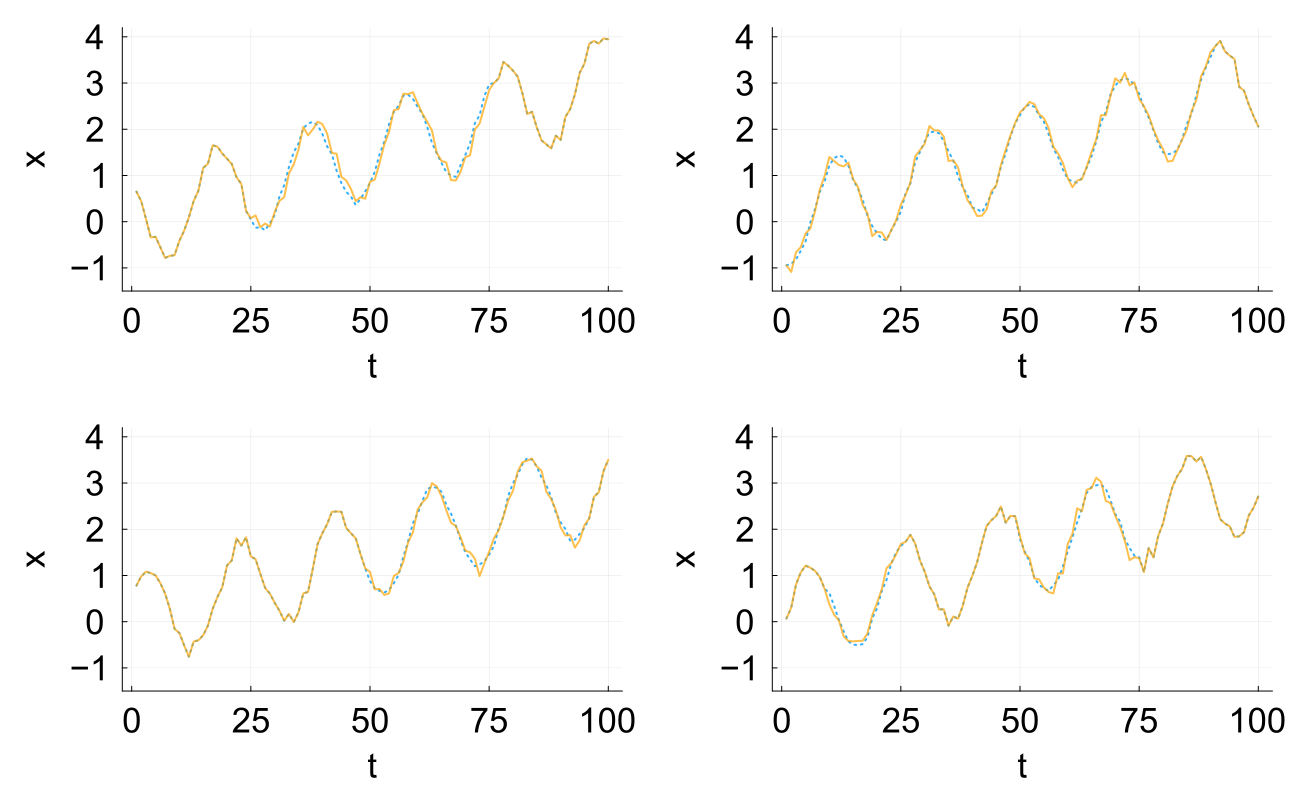

In [97]:
fstyle = font("Arial", 23)
p1 = plot(plots_nts1..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p2 = plot(plots_nts2..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p3 = plot(plots_nts3..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p4 = plot(plots_nts4..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
plot(p1, p2, p3, p4, size=(1300, 800), ylims=(-1.5, 4.2))
#savefig("NTS1_imputation_examples.svg")

# NTS2

In [92]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS2_f = jldopen("NTS2_5_Chi_20_80/NTS2_rand_250_10sw.jld2");
NTS2_res = read(NTS2_f, "res")
losses_NTS2 = NTS2_res[1]["loss"] # get the errors
window_lengths_NTS2= [length(NTS2_res[1]["eval_windows"][i]) for i in 1:length(NTS2_res[1]["eval_windows"])]
NTS2_pm = [mean(losses_NTS2[findall(x -> x .== pm, window_lengths_NTS2)]) for pm in 5:10:95]
NTS2_pm_stds = [std(losses_NTS2[findall(x -> x .== pm, window_lengths_NTS2)]) for pm in 5:10:95]
params_NTS2 = NTS2_res[1]["opts"]
println("Optimal params: d = $(params_NTS2.d), χ = $(params_NTS2.chi_max), η = $(params_NTS2.eta), sweeps = $(params_NTS2.nsweeps)")

Optimal params: d = 11, χ = 80, η = 0.3525499738689916, sweeps = 10


Unique periods [20.0, 30.0, 40.0]
Unique slopes [3.0]
Unique phases [6.238264788303018, 4.727268036591773, 1.3705270322166376, 0.2484157925866959, 4.0463865311345835, 2.1083546727116906, 5.67857845053252, 2.6474244688184916, 2.6404338806476106, 5.007279307565397, 5.055631687724955, 4.207946095630184, 0.4372731060652841, 6.231887453487624, 6.230743056698053, 5.38658436227196, 2.689318800857128, 5.0767708395599085, 1.9685849539475506, 4.3862065569771795, 0.27102800003607525, 1.1047111351916834, 2.9515363643077466, 3.629295065482978, 5.1979619943571524, 3.7867411562976505, 5.4187013712061525, 4.088638385364591, 6.2701898142115216, 0.786479620958144, 5.903989302674292, 1.682781594404335, 3.747907947061441, 2.643608078084833, 6.135528681852549, 4.3091944272529785, 0.20224953340049054, 1.7732635283657765, 5.1139396553632155, 3.2449394737195867, 3.56904716118697, 5.187662742226882, 0.15498007475213443, 6.07348498942452, 3.9118261818705764, 3.248862417020091, 2.1110955251016237, 5.476209289816

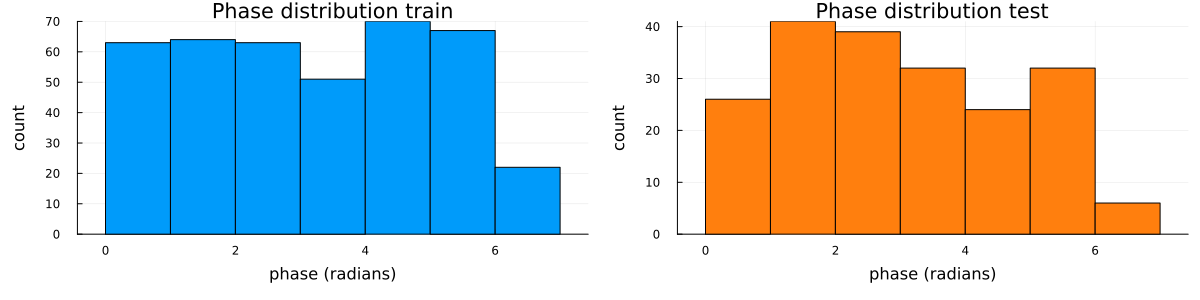

In [93]:
# #load the dataset
nts2_dataset_loaded = jldopen("/Users/jmoo2880/Documents/MPSTime.jl/Folds/NTS/NTS2_dataset.jld2")
NTS2_X_train = read(nts2_dataset_loaded, "X_train")
NTS2_X_test = read(nts2_dataset_loaded, "X_test")
NTS2_train_info = read(nts2_dataset_loaded, "train_info")
NTS2_test_info = read(nts2_dataset_loaded, "test_info")
NTS2_eval_windows = read(nts2_dataset_loaded, "eval_windows");
println("Unique periods $(unique(NTS2_train_info[:period]))")
println("Unique slopes $(unique(NTS2_train_info[:slope]))")
println("Unique phases $(unique(NTS2_train_info[:phase]))")
h3 = histogram(unique(NTS2_train_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution train")
h4 = histogram(unique(NTS2_test_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution test", c=palette(:tab10)[2])
plot(h3, h4, size=(1200, 300), bottom_margin=10mm, left_margin=8mm)

In [94]:
# train NN
opts = MPSOptions(; chi_max=5, d=3, nsweeps=1, sigmoid_transform=false, log_level=-1, verbosity=-5) #doesn't matter, only need the 1NN
mps, _, _ = fitMPS(NTS2_X_train, opts)
imp_NTS2 = init_imputation_problem(mps, NTS2_X_test; verbosity=0)
pms = 5:10:95
pm_losses_NTS2 = []
for pm in pms
    losses = []
    for i in 1:size(NTS2_X_test, 1)
        for window in NTS2_eval_windows[pm]
            out = MPSTime.get_predictions(imp_NTS2, 0, i, window, :kNearestNeighbour)
            loss = MPSTime.compute_all_forecast_metrics(out[1][1][window], NTS2_X_test[i, :][window], false)[:MAE]
            push!(losses, loss)
        end
    end
    push!(pm_losses_NTS2, losses)
end
knn_means_nts2 = mean.(pm_losses_NTS2)
knn_std_nts2 = std.(pm_losses_NTS2)

10-element Vector{Float64}:
 0.03937201758056266
 0.023372364010631717
 0.01845401076887425
 0.016109404720885585
 0.01567997343202471
 0.014447026117375437
 0.013481956554376357
 0.013481246517778784
 0.015281248537575615
 0.26587938104437037

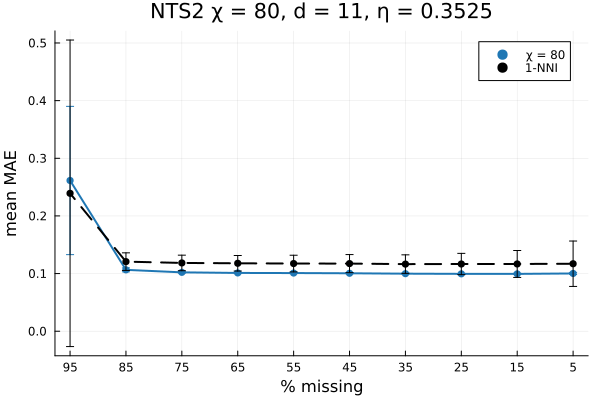

In [95]:
plot(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label="χ = $(params_NTS2.chi_max)", c=palette(:tab10)[1], yerr=NTS2_pm_stds, 
    msc=palette(:tab10)[1])
plot!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts2)
title!("NTS2 χ = $(params_NTS2.chi_max), d = $(params_NTS2.d), η = $(round(params_NTS2.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

# NTS3

In [96]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS3_f = jldopen("NTS2_5_Chi_20_80/NTS3_rand_250_10sw.jld2");
NTS3_res = read(NTS3_f, "res")
losses_NTS3 = NTS3_res[1]["loss"] # get the errors
window_lengths_NTS3 = [length(NTS3_res[1]["eval_windows"][i]) for i in 1:length(NTS3_res[1]["eval_windows"])]
NTS3_pm = [mean(losses_NTS3[findall(x -> x .== pm, window_lengths_NTS3)]) for pm in 5:10:95]
NTS3_pm_stds = [std(losses_NTS3[findall(x -> x .== pm, window_lengths_NTS3)]) for pm in 5:10:95]
params_NTS3 = NTS3_res[1]["opts"]
println("Optimal params: d = $(params_NTS3.d), χ = $(params_NTS3.chi_max), η = $(params_NTS3.eta), sweeps = $(params_NTS3.nsweeps)")

Optimal params: d = 15, χ = 71, η = 0.1889033947807025, sweeps = 10


Unique periods [20.0]
Unique slopes [-3.0, 0.0, 3.0]
Unique phases [6.238264788303018, 4.727268036591773, 1.3705270322166376, 0.2484157925866959, 4.0463865311345835, 2.1083546727116906, 5.67857845053252, 2.6474244688184916, 2.6404338806476106, 5.007279307565397, 5.055631687724955, 4.207946095630184, 0.4372731060652841, 6.231887453487624, 6.230743056698053, 5.38658436227196, 2.689318800857128, 5.0767708395599085, 1.9685849539475506, 4.3862065569771795, 0.27102800003607525, 1.1047111351916834, 2.9515363643077466, 3.629295065482978, 5.1979619943571524, 3.7867411562976505, 5.4187013712061525, 4.088638385364591, 6.2701898142115216, 0.786479620958144, 5.903989302674292, 1.682781594404335, 3.747907947061441, 2.643608078084833, 6.135528681852549, 4.3091944272529785, 0.20224953340049054, 1.7732635283657765, 5.1139396553632155, 3.2449394737195867, 3.56904716118697, 5.187662742226882, 0.15498007475213443, 6.07348498942452, 3.9118261818705764, 3.248862417020091, 2.1110955251016237, 5.4762092898167

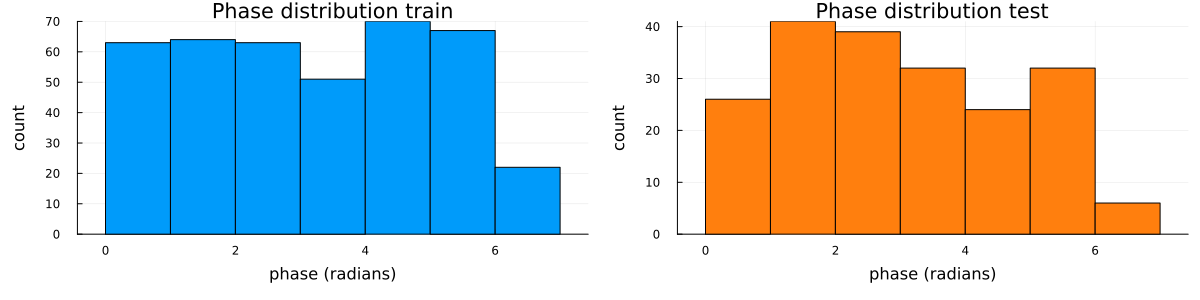

In [97]:
# #load the dataset
nts3_dataset_loaded = jldopen("/Users/jmoo2880/Documents/MPSTime.jl/Folds/NTS/NTS3_dataset.jld2")
NTS3_X_train = read(nts3_dataset_loaded, "X_train")
NTS3_X_test = read(nts3_dataset_loaded, "X_test")
NTS3_train_info = read(nts3_dataset_loaded, "train_info")
NTS3_test_info = read(nts3_dataset_loaded, "test_info")
NTS3_eval_windows = read(nts3_dataset_loaded, "eval_windows");
println("Unique periods $(unique(NTS3_train_info[:period]))")
println("Unique slopes $(unique(NTS3_train_info[:slope]))")
println("Unique phases $(unique(NTS3_train_info[:phase]))")
h5 = histogram(unique(NTS3_train_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution train")
h6 = histogram(unique(NTS3_test_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution test", c=palette(:tab10)[2])
plot(h5, h6, size=(1200, 300), bottom_margin=10mm, left_margin=8mm)

In [98]:
# train NN
opts = MPSOptions(; chi_max=5, d=3, nsweeps=1, sigmoid_transform=false, log_level=-1, verbosity=-5) #doesn't matter, only need the 1NN
mps, _, _ = fitMPS(NTS3_X_train, opts)
imp_NTS3 = init_imputation_problem(mps, NTS3_X_test; verbosity=0)
pms = 5:10:95
pm_losses_NTS3 = []
for pm in pms
    losses = []
    for i in 1:size(NTS3_X_test, 1)
        for window in NTS3_eval_windows[pm]
            out = MPSTime.get_predictions(imp_NTS3, 0, i, window, :kNearestNeighbour)
            loss = MPSTime.compute_all_forecast_metrics(out[1][1][window], NTS3_X_test[i, :][window], false)[:MAE]
            push!(losses, loss)
        end
    end
    push!(pm_losses_NTS3, losses)
end
knn_means_nts3 = mean.(pm_losses_NTS3)
knn_std_nts3 = std.(pm_losses_NTS3)

10-element Vector{Float64}:
 0.0383974907683214
 0.023611726520413667
 0.018884023495981953
 0.016375695095910088
 0.01601659299029244
 0.014748918956772303
 0.01361529222170046
 0.013646400904273038
 0.014722864903438881
 0.6019483503872969

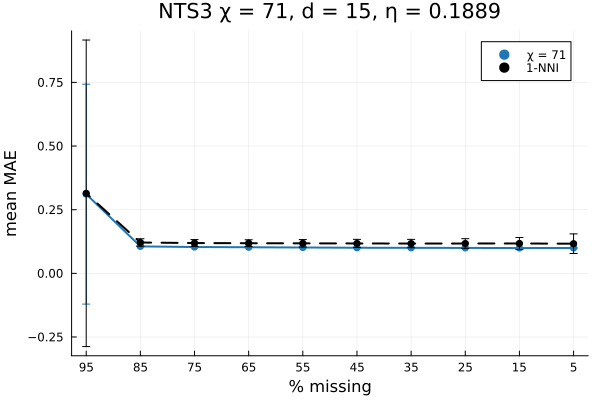

In [99]:
plot(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="χ = $(params_NTS3.chi_max)", c=palette(:tab10)[1], yerr=NTS3_pm_stds, 
    msc=palette(:tab10)[1])
plot!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts3)
title!("NTS3 χ = $(params_NTS3.chi_max), d = $(params_NTS3.d), η = $(round(params_NTS3.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

# NTS4

In [100]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS4_f = jldopen("NTS2_5_Chi_20_80/NTS4_rand_250_10sw.jld2");
NTS4_res = read(NTS4_f, "res")
losses_NTS4 = NTS4_res[1]["loss"] # get the errors
window_lengths_NTS4 = [length(NTS4_res[1]["eval_windows"][i]) for i in 1:length(NTS4_res[1]["eval_windows"])]
NTS4_pm = [mean(losses_NTS4[findall(x -> x .== pm, window_lengths_NTS4)]) for pm in 5:10:95]
NTS4_pm_stds = [std(losses_NTS4[findall(x -> x .== pm, window_lengths_NTS4)]) for pm in 5:10:95]
params_NTS4 = NTS4_res[1]["opts"]
println("Optimal params: d = $(params_NTS4.d), χ = $(params_NTS4.chi_max), η = $(params_NTS4.eta), sweeps = $(params_NTS4.nsweeps)")

Optimal params: d = 11, χ = 80, η = 0.3525499738689916, sweeps = 10


Unique periods [20.0, 40.0]
Unique slopes [3.0, -3.0]
Unique phases [2.2464237571777557, 1.7212749610784077, 3.7797233744305356, 2.12831940011615, 5.970361651148794, 1.0920072449616924, 4.457895698877682, 2.0215775534742004, 1.9224350651635478, 5.974401132282982, 4.390631290521938, 0.007863755804782427, 3.757439128219067, 4.6746230761999366, 5.916542470614568, 4.857539108667177, 3.7891598735305094, 0.892939940003824, 3.6495434431109106, 2.11448942446242, 4.754314623313788, 2.1847609998845794, 3.140647875914827, 0.5500083485410938, 3.2584133140466944, 2.346411544954018, 4.607104263689064, 1.3702101823727082, 4.9309589144541714, 5.452093234276585, 5.311856215242578, 0.44247694095377993, 4.325284575552677, 2.2844582016642705, 3.859244784143885, 0.9958592410413926, 1.2527581109155437, 5.956910902600855, 5.804881562142691, 5.216053206818463, 5.237157790153894, 4.660848105301729, 3.3627174314994273, 0.830100891992927, 3.7745593505649735, 3.5276040432586293, 3.432012507948365, 1.1150889226951

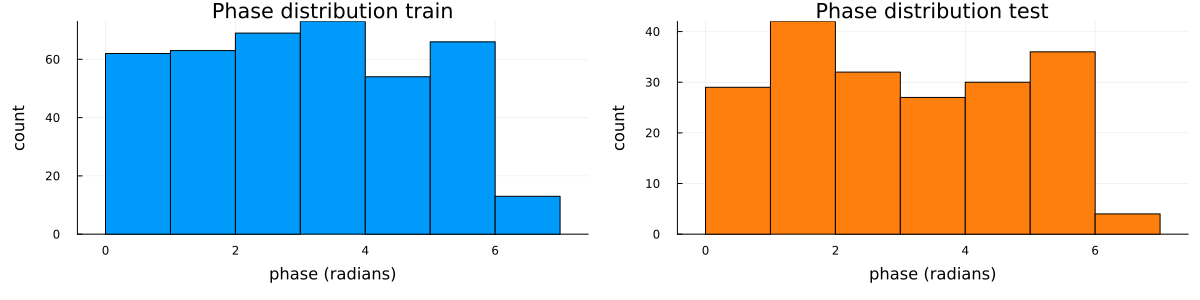

In [101]:
# #load the dataset
nts4_dataset_loaded = jldopen("/Users/jmoo2880/Documents/MPSTime.jl/Folds/NTS/NTS4_dataset.jld2")
NTS4_X_train = read(nts4_dataset_loaded, "X_train")
NTS4_X_test = read(nts4_dataset_loaded, "X_test")
NTS4_train_info = read(nts4_dataset_loaded, "train_info")
NTS4_test_info = read(nts4_dataset_loaded, "test_info")
NTS4_eval_windows = read(nts4_dataset_loaded, "eval_windows");
println("Unique periods $(unique(NTS4_train_info[:period]))")
println("Unique slopes $(unique(NTS4_train_info[:slope]))")
println("Unique phases $(unique(NTS4_train_info[:phase]))")
h7 = histogram(unique(NTS4_train_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution train")
h8 = histogram(unique(NTS4_test_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution test", c=palette(:tab10)[2])
plot(h7, h8, size=(1200, 300), bottom_margin=10mm, left_margin=8mm)

In [102]:
# train NN
opts = MPSOptions(; chi_max=5, d=3, nsweeps=1, sigmoid_transform=false, log_level=-1, verbosity=-5) #doesn't matter, only need the 1NN
mps, _, _ = fitMPS(NTS4_X_train, opts)
imp_NTS4 = init_imputation_problem(mps, NTS4_X_test; verbosity=0)
pms = 5:10:95
pm_losses_NTS4 = []
for pm in pms
    losses = []
    for i in 1:size(NTS4_X_test, 1)
        for window in NTS4_eval_windows[pm]
            out = MPSTime.get_predictions(imp_NTS4, 0, i, window, :kNearestNeighbour)
            loss = MPSTime.compute_all_forecast_metrics(out[1][1][window], NTS4_X_test[i, :][window], false)[:MAE]
            push!(losses, loss)
        end
    end
    push!(pm_losses_NTS4, losses)
end
knn_means_nts4 = mean.(pm_losses_NTS4)
knn_std_nts4 = std.(pm_losses_NTS4)

10-element Vector{Float64}:
 0.039272340264140615
 0.02432311113147632
 0.018368258805294874
 0.0163594022756876
 0.014886927867094547
 0.014762717858218729
 0.01464016934977218
 0.014760171932958352
 0.016781356349556204
 0.7882243032821464

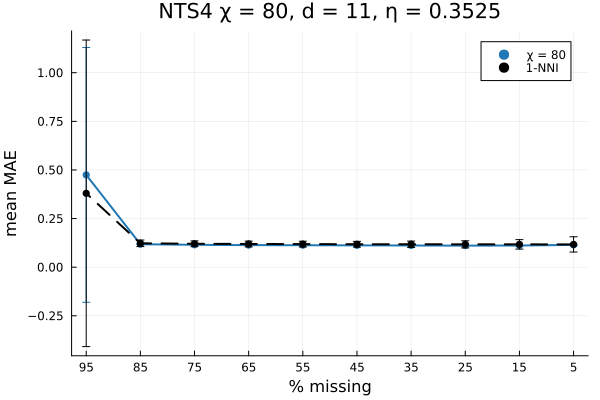

In [103]:
plot(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label="χ = $(params_NTS4.chi_max)", c=palette(:tab10)[1], yerr=NTS4_pm_stds, 
    msc=palette(:tab10)[1])
plot!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts4)
title!("NTS4 χ = $(params_NTS4.chi_max), d = $(params_NTS4.d), η = $(round(params_NTS4.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

# NTS5

In [104]:
# get the saved results - 250 iterations/evaluated models, chi 20, 10 sweeps
NTS5_f = jldopen("NTS2_5_Chi_20_80/NTS5_rand_50_10sw_chi20_150.jld2");
NTS5_res = read(NTS5_f, "res")
losses_NTS5 = NTS5_res[1]["loss"] # get the errors
window_lengths_NTS5 = [length(NTS5_res[1]["eval_windows"][i]) for i in 1:length(NTS5_res[1]["eval_windows"])]
NTS5_pm = [mean(losses_NTS5[findall(x -> x .== pm, window_lengths_NTS5)]) for pm in 5:10:95]
NTS5_pm_stds = [std(losses_NTS5[findall(x -> x .== pm, window_lengths_NTS5)]) for pm in 5:10:95]
params_NTS5 = NTS5_res[1]["opts"]
println("Optimal params: d = $(params_NTS5.d), χ = $(params_NTS5.chi_max), η = $(params_NTS5.eta), sweeps = $(params_NTS5.nsweeps)")

Optimal params: d = 15, χ = 160, η = 0.1256605314896181, sweeps = 10


Unique periods [20.0, 30.0, 40.0]
Unique slopes [-3.0, 3.0, 0.0]
Unique phases [4.384685950754773, 5.045378594913256, 2.0463090188000903, 0.9753484199530923, 6.174007055629468, 6.212698385608892, 0.7691305621148632, 4.57503361707517, 0.17140979113389895, 6.094127883992284, 3.3404824146428256, 0.59415698876192, 1.8590958680807244, 1.2218236563355187, 1.2791678239130457, 0.3599372691361795, 5.278589208819761, 3.8349589530997434, 5.511272360426614, 1.3977319917754552, 4.257971338243795, 0.7364416419366852, 1.4765044340533973, 3.178883977390441, 1.74341106453214, 2.8950555134808718, 3.153011703958486, 3.9373266289486293, 5.230888098727537, 4.20517896757778, 0.22619937059304374, 4.663301812434992, 4.662336602467782, 5.949860045538957, 2.417442661983616, 5.069384986674644, 0.016488922070341663, 5.032933117995547, 0.08396446265371696, 3.468191147111853, 5.4286914780923885, 3.2486513557832346, 1.6301396021020929, 5.127113892237238, 2.315126541378213, 0.6209907614810514, 5.094080328245419, 1.30

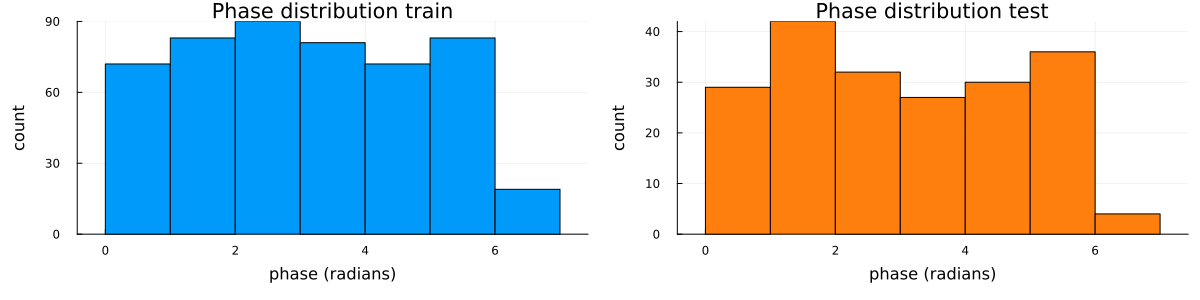

In [105]:
# #load the dataset
nts5_dataset_loaded = jldopen("/Users/jmoo2880/Documents/MPSTime.jl/Folds/NTS/NTS5_dataset.jld2")
NTS5_X_train = read(nts5_dataset_loaded, "X_train")
NTS5_X_test = read(nts5_dataset_loaded, "X_test")
NTS5_train_info = read(nts5_dataset_loaded, "train_info")
NTS5_test_info = read(nts5_dataset_loaded, "test_info")
NTS5_eval_windows = read(nts5_dataset_loaded, "eval_windows");
println("Unique periods $(unique(NTS5_train_info[:period]))")
println("Unique slopes $(unique(NTS5_train_info[:slope]))")
println("Unique phases $(unique(NTS5_train_info[:phase]))")
h9 = histogram(unique(NTS5_train_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution train")
h10 = histogram(unique(NTS5_test_info[:phase]), xlabel="phase (radians)", ylabel="count", label=:none, title="Phase distribution test", c=palette(:tab10)[2])
plot(h9, h10, size=(1200, 300), bottom_margin=10mm, left_margin=8mm)

In [106]:
# train NN
opts = MPSOptions(; chi_max=5, d=3, nsweeps=1, sigmoid_transform=false, log_level=-1, verbosity=-5) #doesn't matter, only need the 1NN
mps, _, _ = fitMPS(NTS5_X_train, opts)
imp_NTS5 = init_imputation_problem(mps, NTS5_X_test; verbosity=0)
pms = 5:10:95
pm_losses_NTS5 = []
for pm in pms
    losses = []
    for i in 1:size(NTS5_X_test, 1)
        for window in NTS5_eval_windows[pm]
            out = MPSTime.get_predictions(imp_NTS5, 0, i, window, :kNearestNeighbour)
            loss = MPSTime.compute_all_forecast_metrics(out[1][1][window], NTS5_X_test[i, :][window], false)[:MAE]
            push!(losses, loss)
        end
    end
    push!(pm_losses_NTS5, losses)
end
knn_means_nts5 = mean.(pm_losses_NTS5)
knn_std_nts5 = std.(pm_losses_NTS5)

10-element Vector{Float64}:
 0.04695871938521359
 0.030839498623910517
 0.026508854184214035
 0.02453024884342205
 0.02337867133121668
 0.023008541398215614
 0.022694566941768
 0.022356190783855673
 0.07171667076898831
 0.6060300277597599

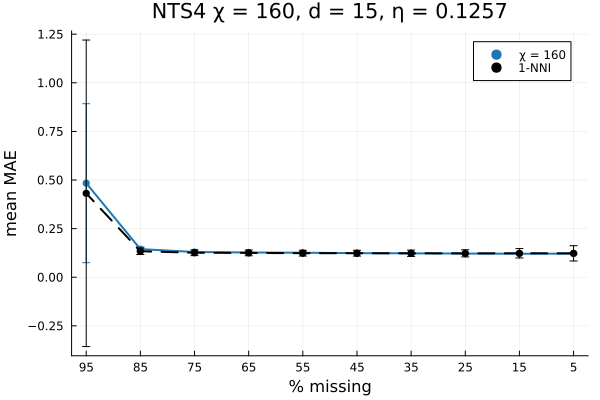

In [107]:
plot(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright)
scatter!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label="χ = $(params_NTS5.chi_max)", c=palette(:tab10)[1], yerr=NTS5_pm_stds, 
    msc=palette(:tab10)[1])
plot!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, lw=2, c=:black, ls=:dash)
scatter!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label="1-NNI", c=:black, ms=4, yerr=knn_std_nts4)
title!("NTS4 χ = $(params_NTS5.chi_max), d = $(params_NTS5.d), η = $(round(params_NTS5.eta; digits=4))")
xlabel!("% missing")
ylabel!("mean MAE")
xflip!(true)

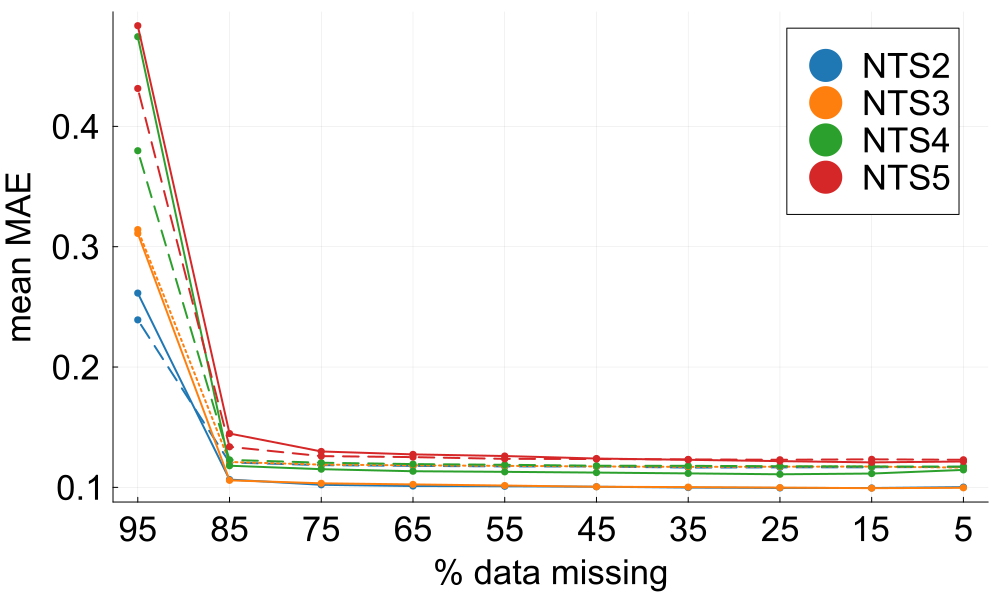

In [131]:
plot(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright, size=(1000, 600),
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, legendfont=fstyle, left_margin=5mm, bottom_margin=8mm)
scatter!(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label="NTS2", c=palette(:tab10)[1], msw=0)

plot!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[1], ms=4, msw=0)

plot!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="", lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="NTS3", c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], ls=:dot)
scatter!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, ms=4, c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label="NTS4", c=palette(:tab10)[3], msw=0)

plot!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[3], ms=4, msw=0)

plot!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], legend=:topright)
scatter!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label="NTS5", c=palette(:tab10)[4], msw=0)

plot!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[4], ms=4, msw=0)

xlabel!("% data missing")
ylabel!("mean MAE")
xflip!(true)
#savefig("NTS2_5_lineplot.svg")

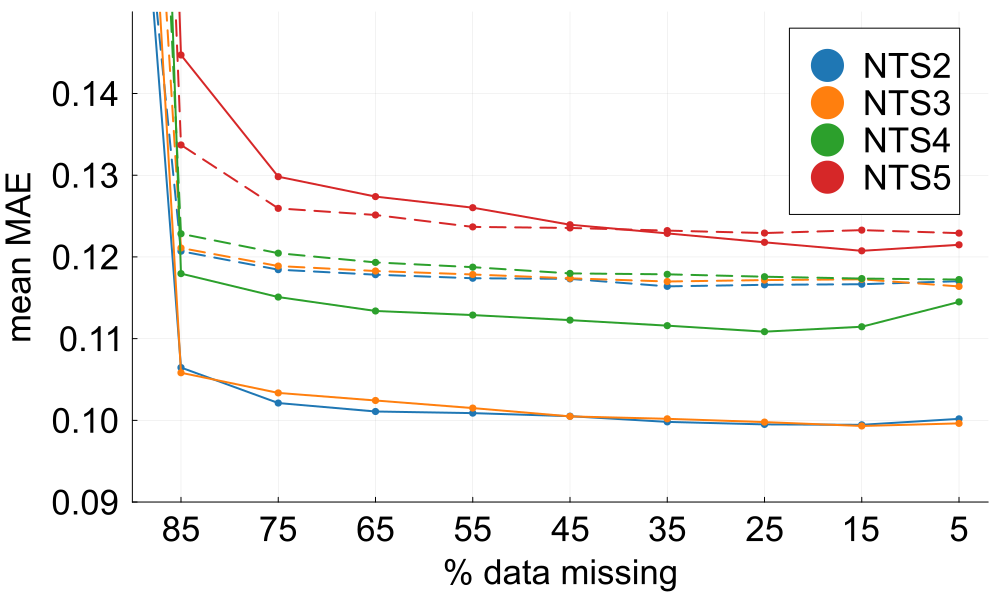

In [136]:
plot(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright, size=(1000, 600),
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, legendfont=fstyle, left_margin=5mm, bottom_margin=8mm)
scatter!(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label="NTS2", c=palette(:tab10)[1], msw=0)

plot!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[1], ms=4, msw=0)

plot!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="", lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="NTS3", c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, ms=4, c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label="NTS4", c=palette(:tab10)[3], msw=0)

plot!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[3], ms=4, msw=0)

plot!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], legend=:topright)
scatter!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label="NTS5", c=palette(:tab10)[4], msw=0)

plot!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[4], ms=4, msw=0)

xlims!(2, 90)
ylims!(0.09, 0.15)
xlabel!("% data missing")
ylabel!("mean MAE")
xflip!(true)
#savefig("NTS2_5_lineplot_85_5_inset.svg")

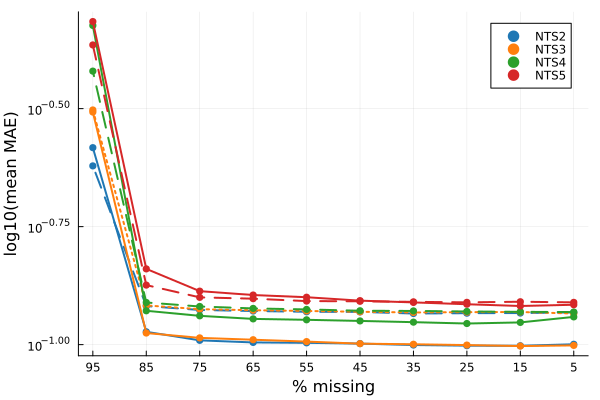

In [110]:
plot(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], legend=:topright, yscale=:log10)
scatter!(collect(5:10:95), NTS2_pm, xticks=collect(5:10:95), label="NTS2", c=palette(:tab10)[1], msw=0)

plot!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[1], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts2, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[1], ms=4, msw=0)

plot!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="", lw=2, c=palette(:tab10)[2], legend=:topright)
scatter!(collect(5:10:95), NTS3_pm, xticks=collect(5:10:95), label="NTS3", c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[2], ls=:dot)
scatter!(collect(5:10:95), knn_means_nts3, xticks=collect(5:10:95), label=:none, ms=4, c=palette(:tab10)[2], msw=0)

plot!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], legend=:topright)
scatter!(collect(5:10:95), NTS4_pm, xticks=collect(5:10:95), label="NTS4", c=palette(:tab10)[3], msw=0)

plot!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[3], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts4, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[3], ms=4, msw=0)

plot!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], legend=:topright)
scatter!(collect(5:10:95), NTS5_pm, xticks=collect(5:10:95), label="NTS5", c=palette(:tab10)[4], msw=0)

plot!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, lw=2, c=palette(:tab10)[4], ls=:dash)
scatter!(collect(5:10:95), knn_means_nts5, xticks=collect(5:10:95), label=:none, c=palette(:tab10)[4], ms=4, msw=0)

xlabel!("% missing")
ylabel!("log10(mean MAE)")
xflip!(true)

Barplot version

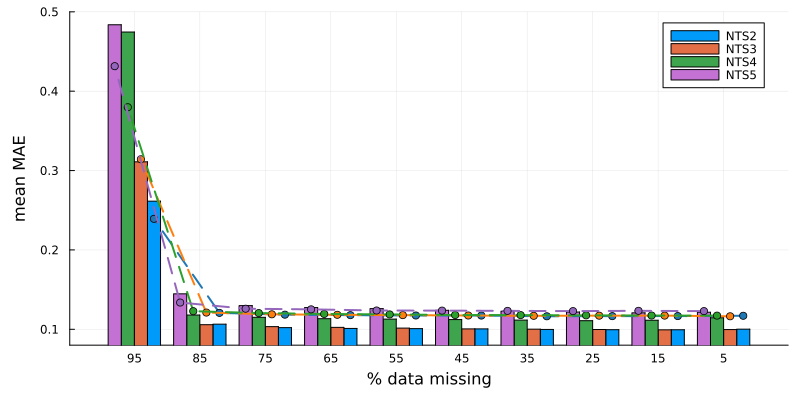

In [308]:
groupedbar(collect(5:10:95), [NTS2_pm NTS3_pm NTS4_pm NTS5_pm],
    label=["NTS2" "NTS3" "NTS4" "NTS5" "NTS6"],
    xticks=collect(5:10:95),
    legend=:topright,
    ylims=(0.08, 0.5),
    ylabel="mean MAE",
    xlabel="% data missing",
    size=(800, 400),
    bottom_margin=5mm, left_margin=5mm)

plot!(collect(5:10:95).-3, knn_means_nts2, c=palette(:tab10)[1], ls=:dash, lw=2, label=:none)
scatter!(collect(5:10:95).-3, knn_means_nts2, c=palette(:tab10)[1], label=:none)


plot!(collect(5:10:95).-1, knn_means_nts3, c=palette(:tab10)[2], ls=:dash, lw=2, label=:none)
scatter!(collect(5:10:95).-1, knn_means_nts3, c=palette(:tab10)[2], label=:none)

plot!(collect(5:10:95).+1, knn_means_nts4, c=palette(:tab10)[3], ls=:dash, lw=2, label=:none)
scatter!(collect(5:10:95).+1, knn_means_nts4, c=palette(:tab10)[3], label=:none)

plot!(collect(5:10:95).+3, knn_means_nts5, c=palette(:tab10)[5], ls=:dash, lw=2, label=:none)
scatter!(collect(5:10:95).+3, knn_means_nts5, c=palette(:tab10)[5], label=:none)


xflip!(true)

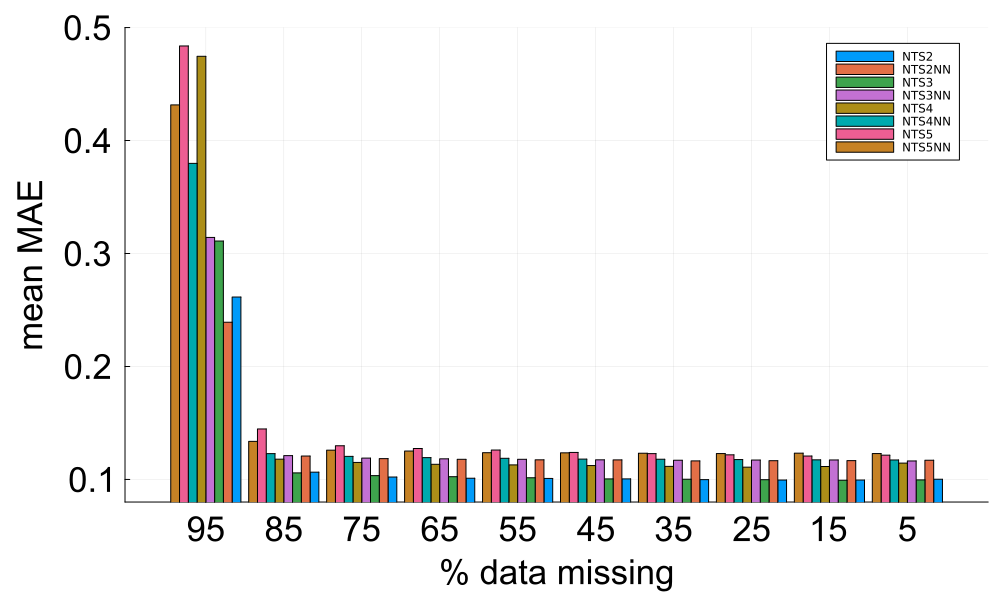

In [ ]:
fstyle = font("Arial", 23)
groupedbar(collect(5:10:95), [NTS2_pm knn_means_nts2 NTS3_pm knn_means_nts3 NTS4_pm knn_means_nts4 NTS5_pm knn_means_nts5],
    label=["NTS2" "NTS2NN" "NTS3" "NTS3NN" "NTS4" "NTS4NN" "NTS5" "NTS5NN"],
    xticks=collect(5:10:95),
    legend=:topright,
    ylims=(0.08, 0.5),
    ylabel="mean MAE",
    xlabel="% data missing",
    size=(1000, 600),
    bottom_margin=8mm,
    left_margin=8mm,
    top_margin=5mm,
    guidefont=fstyle,
    xtickfont=fstyle,
    ytickfont=fstyle,
    bar_width = 9)

xflip!(true)
#savefig("NTS3_5_paper_final.svg")

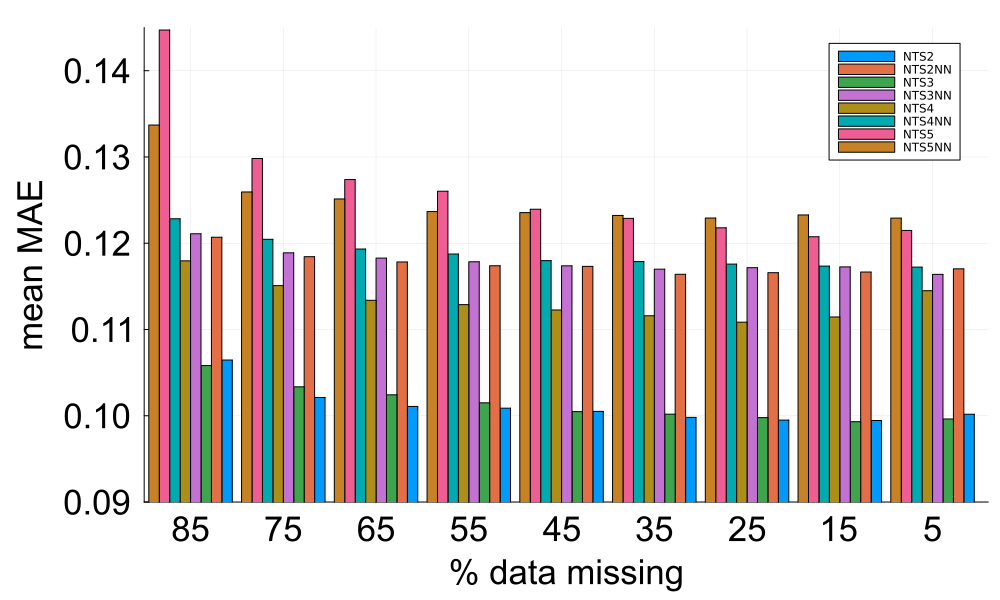

In [402]:
fstyle = font("Arial", 23)
groupedbar(collect(5:10:95), [NTS2_pm knn_means_nts2 NTS3_pm knn_means_nts3 NTS4_pm knn_means_nts4 NTS5_pm knn_means_nts5],
    label=["NTS2" "NTS2NN" "NTS3" "NTS3NN" "NTS4" "NTS4NN" "NTS5" "NTS5NN"],
    xticks=collect(5:10:95),
    legend=:topright,
    ylims=(0.08, 0.5),
    ylabel="mean MAE",
    xlabel="% data missing",
    size=(1000, 600),
    bottom_margin=8mm,
    left_margin=8mm,
    top_margin=5mm,
    guidefont=fstyle,
    xtickfont=fstyle,
    ytickfont=fstyle,
    bar_width = 9)
xlims!(-1, 90)
ylims!(0.09, 0.145)
xflip!(true)
#savefig("NTS3_5_paper_final_inset_zoom.svg")

# NTS5 Imputation Examples

In [ ]:
opts_NTS5_rec = MPSOptions(; d=params_NTS5.d, chi_max=params_NTS5.chi_max, nsweeps=params_NTS5.nsweeps, eta=params_NTS5.eta, sigmoid_transform=false, log_level=-1, verbosity=-5)
#mps, _, _ = fitMPS(NTS5_X_train, opts_NTS5_rec)

ImputationProblem(ITensors.ITensorMPS.MPS[ITensors.ITensorMPS.MPS
[1] ((dim=15|id=750|"Site,n=1"), (dim=9|id=477|"Link,l=1"))
[2] ((dim=15|id=707|"Site,n=2"), (dim=9|id=477|"Link,l=1"), (dim=40|id=222|"Link,l=2"))
[3] ((dim=15|id=588|"Site,n=3"), (dim=40|id=222|"Link,l=2"), (dim=133|id=316|"Link,l=3"))
[4] ((dim=15|id=457|"Site,n=4"), (dim=133|id=316|"Link,l=3"), (dim=160|id=823|"Link,l=4"))
[5] ((dim=15|id=939|"Site,n=5"), (dim=160|id=823|"Link,l=4"), (dim=160|id=589|"Link,l=5"))
[6] ((dim=15|id=569|"Site,n=6"), (dim=160|id=589|"Link,l=5"), (dim=160|id=480|"Link,l=6"))
[7] ((dim=15|id=450|"Site,n=7"), (dim=160|id=480|"Link,l=6"), (dim=160|id=303|"Link,l=7"))
[8] ((dim=15|id=788|"Site,n=8"), (dim=160|id=303|"Link,l=7"), (dim=160|id=795|"Link,l=8"))
[9] ((dim=15|id=801|"Site,n=9"), (dim=160|id=795|"Link,l=8"), (dim=160|id=32|"Link,l=9"))
[10] ((dim=15|id=228|"Site,n=10"), (dim=160|id=32|"Link,l=9"), (dim=160|id=893|"Link,l=10"))
[11] ((dim=15|id=587|"Site,n=11"), (dim=160|id=893|"Link,l

Load saved MPS

In [ ]:
JLD2.@load "NTS5_mps_trained.jld2" mps

In [ ]:
imp_NTS5 = init_imputation_problem(mps, NTS5_X_test; verbosity=0)

In [50]:
NTS5_eval_windows[75]

5-element Vector{Vector{Int64}}:
 [23, 24, 25, 26, 27, 28, 29, 30, 31, 32  …  88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21  …  77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26  …  82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29  …  85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16  …  72, 73, 74, 75, 76, 77, 78, 79, 80, 81]

In [87]:
imputed_ts_nts5_ex1, pred_err_nts5_ex1, target_ts_nts5_ex1, stats_nts5_ex1, plots_nts5_ex1 = MPS_impute(imp_NTS5, 0, 3, NTS5_eval_windows[65][1], :median, NN_baseline=false; get_wmad=true)
imputed_ts_nts5_ex2, pred_err_nts5_ex2, target_ts_nts5_ex2, stats_nts5_ex2, plots_nts5_ex2 = MPS_impute(imp_NTS5, 0, 7, NTS5_eval_windows[75][1], :median, NN_baseline=false; get_wmad=true)
imputed_ts_nts5_ex3, pred_err_nts5_ex3, target_ts_nts5_ex3, stats_nts5_ex3, plots_nts5_ex3 = MPS_impute(imp_NTS5, 0, 24, NTS5_eval_windows[55][2], :median, NN_baseline=false; get_wmad=true)
imputed_ts_nts5_ex4, pred_err_nts5_ex4, target_ts_nts5_ex4, stats_nts5_ex4, plots_nts5_ex4 = MPS_impute(imp_NTS5, 0, 25, vcat(collect(5:25), collect(35:65), collect(85:95)), :median, NN_baseline=false; get_wmad=true)

([[0.8173959911242443, 1.0229472502683201, 1.0629922319174465, 0.7508260851731396, 0.3722206137056876, 0.17798206670084316, 0.05565310943821711, -0.46920424097912816, -0.7270869076408792, -0.8737990016551764  …  -0.8684264460997237, -0.9023148734495048, -0.7886646597764577, -0.6535242238815977, -0.40432030080942516, -0.17735305743360819, 0.0032145169105310956, 0.40079489464422124, 0.7619261061561033, 0.757258779613073]], [[0.0, 0.0, 0.0, 0.0, 0.24074302748657406, 0.23225970939728224, 0.22727431405563436, 0.2397713348201509, 0.22588175298425117, 0.2211358761541362  …  0.22109906687349756, 0.22197936434278498, 0.22276615859644355, 0.23184643589301634, 0.2405251794825949, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.8173959911242444, 1.0229472502683197, 1.0629922319174465, 0.7508260851731396, 0.6650013717443765, 0.20903503926284953, -0.09316511705081851, -0.37571448216010545, -0.4776491407529424, -0.9394118060676839  …  -0.9999622632123191, -1.1202469433585946, -0.8481850812605025, -0.7585874432111839, 

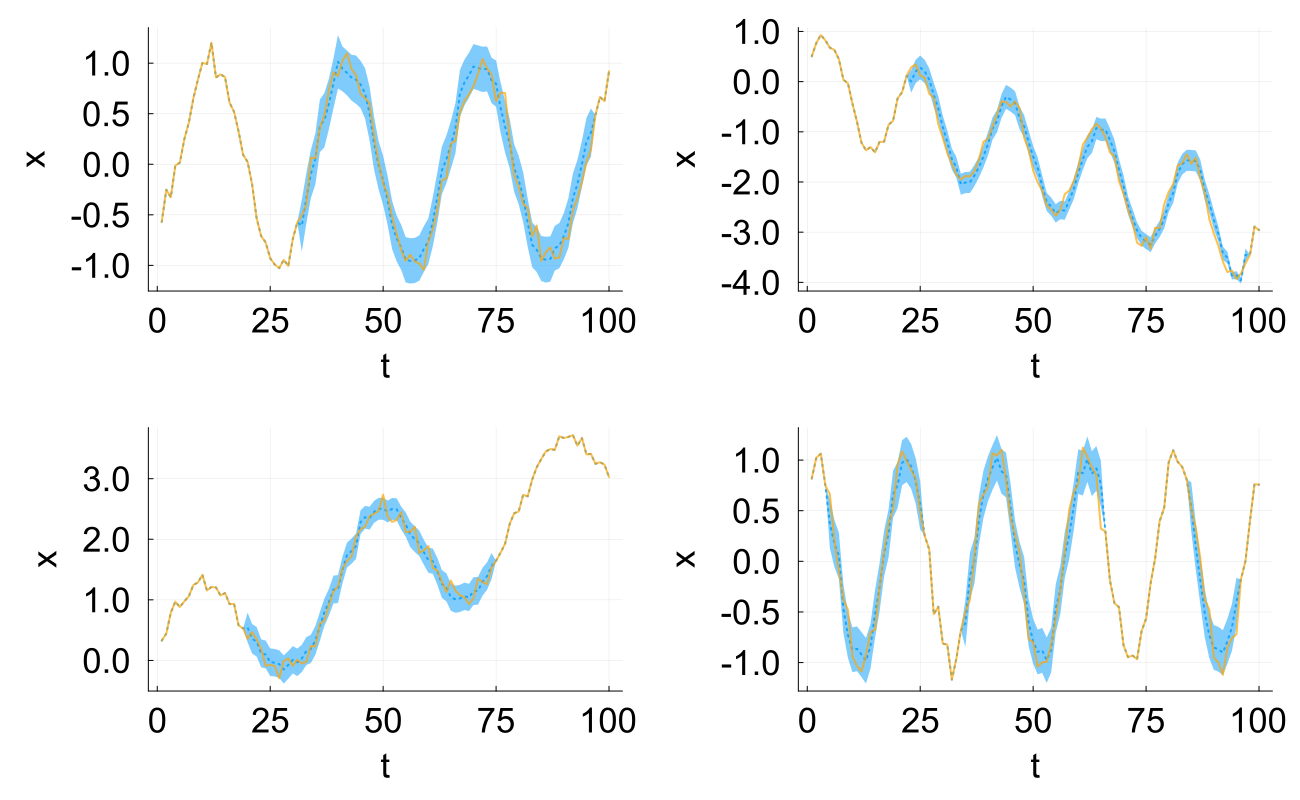

In [90]:
fstyle = font("Arial", 23)
one_dec(x) = @sprintf("%.1f", x)
p1 = plot(plots_nts5_ex1..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p2 = plot(plots_nts5_ex2..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p3 = plot(plots_nts5_ex3..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
p4 = plot(plots_nts5_ex4..., legend=:none, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, bottom_margin=10mm, right_margin=5mm, left_margin=10mm, xlabel="t", title="")
plot(p1, p2, p3, p4, size=(1300, 800), yformatter = one_dec)
#savefig("NTS5_imputation_examples.svg")